## MRI Exploratory Data Analysis

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mri_data_path = "../data/MRI/training/"

patients = sorted(os.listdir(mri_data_path))
print("Total Patients:", len(patients))
print("Sample Patients:", patients[:5])

Total Patients: 100
Sample Patients: ['patient001', 'patient002', 'patient003', 'patient004', 'patient005']


### Metadata EDA

In [3]:
sample_patient = patients[0]
patient_folder = os.path.join(mri_data_path, sample_patient)

info_file = os.path.join(patient_folder, "Info.cfg")
with open(info_file, "r") as f:
    metadata = f.readlines()

print("Metadata for", sample_patient)
for line in metadata:
    print(line.strip())

Metadata for patient001
ED: 1
ES: 12
Group: DCM
Height: 184.0
NbFrame: 30
Weight: 95.0


In [4]:
mri_data_path = "../data/MRI/training/"
metadata_list = []

patients = sorted(os.listdir(mri_data_path))
for patient in patients:
    patient_folder = os.path.join(mri_data_path, patient)
    info_file = os.path.join(patient_folder, "Info.cfg")

    if os.path.exists(info_file):
        with open(info_file, "r") as f:
            lines = f.readlines()

        patient_data = {"Patient_ID": patient}
        for line in lines:
            if ":" in line:
                key, value = line.strip().split(": ")
                patient_data[key] = value
        
        metadata_list.append(patient_data)

metadata_df = pd.DataFrame(metadata_list)

In [5]:
metadata_df.head()

,Patient_ID,ED,ES,Group,Height,NbFrame,Weight
0,patient001,1,12,DCM,184.0,30,95.0
1,patient002,1,12,DCM,160.0,30,70.0
2,patient003,1,15,DCM,165.0,30,77.0
3,patient004,1,15,DCM,159.0,28,46.0
4,patient005,1,13,DCM,165.0,30,77.0


In [6]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Patient_ID  100 non-null    object
 1   ED          100 non-null    object
 2   ES          100 non-null    object
 3   Group       100 non-null    object
 4   Height      100 non-null    object
 5   NbFrame     100 non-null    object
 6   Weight      100 non-null    object
dtypes: object(7)
memory usage: 5.6+ KB


There are no nulls, and the data types of all attributes is object.
Before getting to the basic statistics, the columns Height, NbFrame and Weight need to be converted to numerical type first.

In [7]:
metadata_df['Height'] = pd.to_numeric(metadata_df['Height'], errors='coerce')
metadata_df['NbFrame'] = pd.to_numeric(metadata_df['NbFrame'], errors='coerce')
metadata_df['Weight'] = pd.to_numeric(metadata_df['Weight'], errors='coerce')

In [8]:
metadata_df.describe()

,Height,NbFrame,Weight
count,100.000000,100.000000,100.000000
mean,170.840000,26.980000,74.960000
std,9.710683,6.078576,16.632037
min,140.000000,12.000000,35.000000
25%,165.000000,25.000000,62.750000
50%,171.500000,30.000000,75.000000
75%,178.000000,30.000000,85.000000
max,192.000000,35.000000,123.000000


NbFrame shows the number of frames in the cine-MRI sequence for a given patient, so it's not important to analyze here.
Looking at the statistics of Height and Weight variables, they look balanced, and visualizations will help us identify skewness better. There are no abnormally small or large values, and there were no nulls either, so there is no need for data imputation or outlier handling.

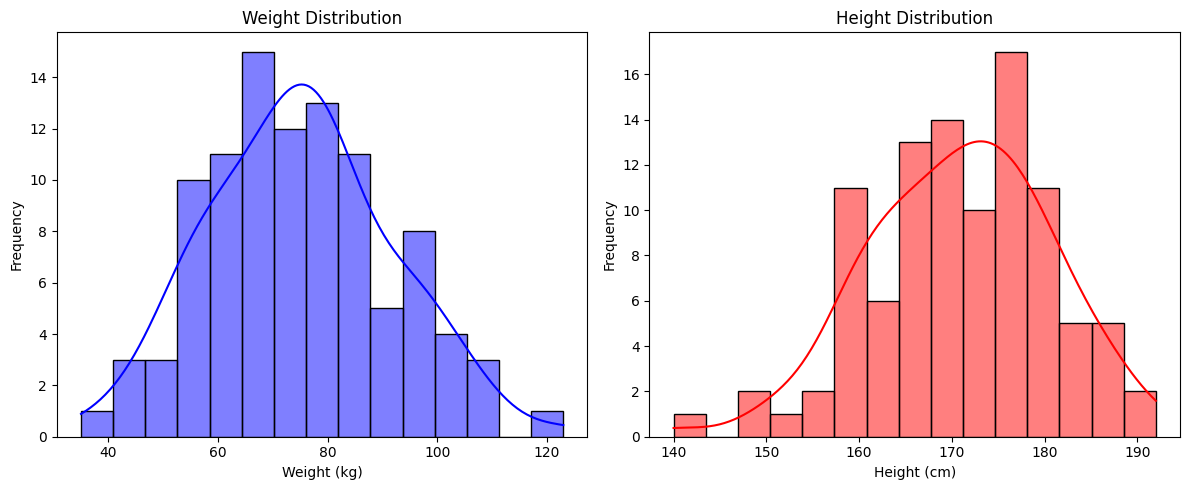

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Histogram for Weight
sns.histplot(metadata_df["Weight"], bins=15, kde=True, color="blue", ax=axes[0])
axes[0].set_title("Weight Distribution")
axes[0].set_xlabel("Weight (kg)")
axes[0].set_ylabel("Frequency")

# Histogram for Height
sns.histplot(metadata_df["Height"], bins=15, kde=True, color="red", ax=axes[1])
axes[1].set_title("Height Distribution")
axes[1].set_xlabel("Height (cm)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

The distributions for Weight and Height attributes are almost unimodal, having similarity with normal distribution, without heavy skewness or kurtosis.

With a scatterplot, we can also check if certain conditions are more common in heavier/lighter or shorter/taller patients.

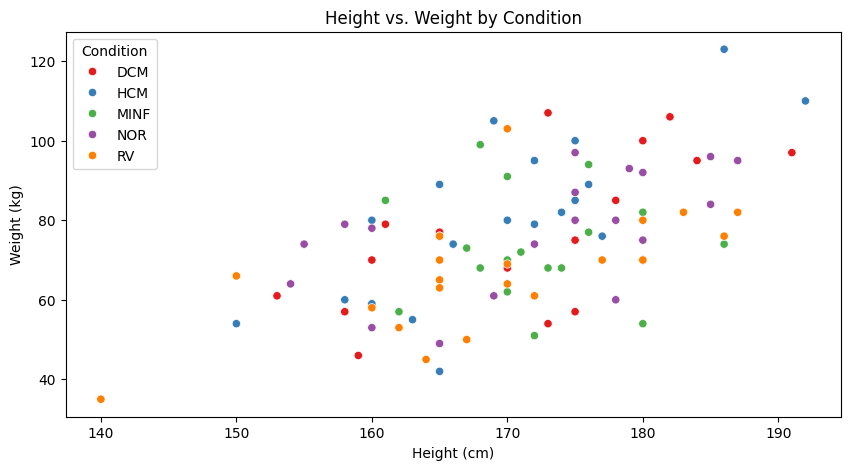

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=metadata_df["Height"], y=metadata_df["Weight"], hue=metadata_df["Group"], palette="Set1")
plt.title("Height vs. Weight by Condition")
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.legend(title="Condition")
plt.show()

In [31]:
condition_stats = metadata_df.groupby("Group")[["Weight", "Height"]].mean()
print(condition_stats)

       Weight  Height
Group                
DCM     75.50  171.10
HCM     80.35  169.75
MINF    74.15  172.20
NOR     77.90  172.25
RV      66.90  168.90


There is no significant difference between heights across the diseases, but patients with RV have significantly less weight nad patients with HCM have more weight than the others on average.

Also, before moving forward, we should note that there is no class imbalance in this dataset: there are 20 healthy patients in the test data, and 20 patients with each condition (100 patients in total).

### MRI Scans

Loading a sample MRI scan

In [10]:
sample_nifti_file = os.path.join(os.path.join(mri_data_path, patients[0]), "patient001_4d.nii.gz")
img = nib.load(sample_nifti_file)

img_data = img.get_fdata()
print("MRI Shape:", img_data.shape)

MRI Shape: (216, 256, 10, 30)


Visualizing a random slice

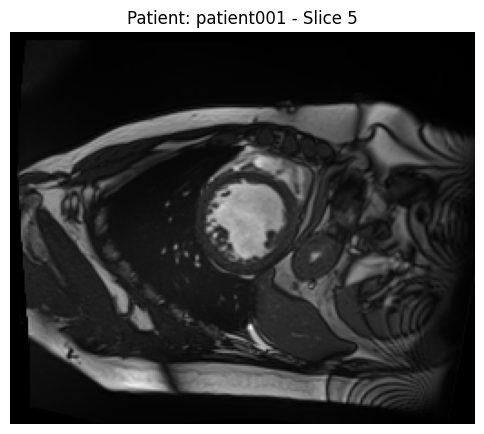

In [11]:
slice_idx = img_data.shape[2] // 2  

plt.figure(figsize=(6,6))
plt.imshow(img_data[:, :, slice_idx, 0], cmap="gray")
plt.title(f"Patient: {sample_patient} - Slice {slice_idx}")
plt.axis("off")
plt.show()

The scan looks well-contrasted and I don't think there is missing parts in the image. We can confirm this by looking at some MRI scans of multiple patients.

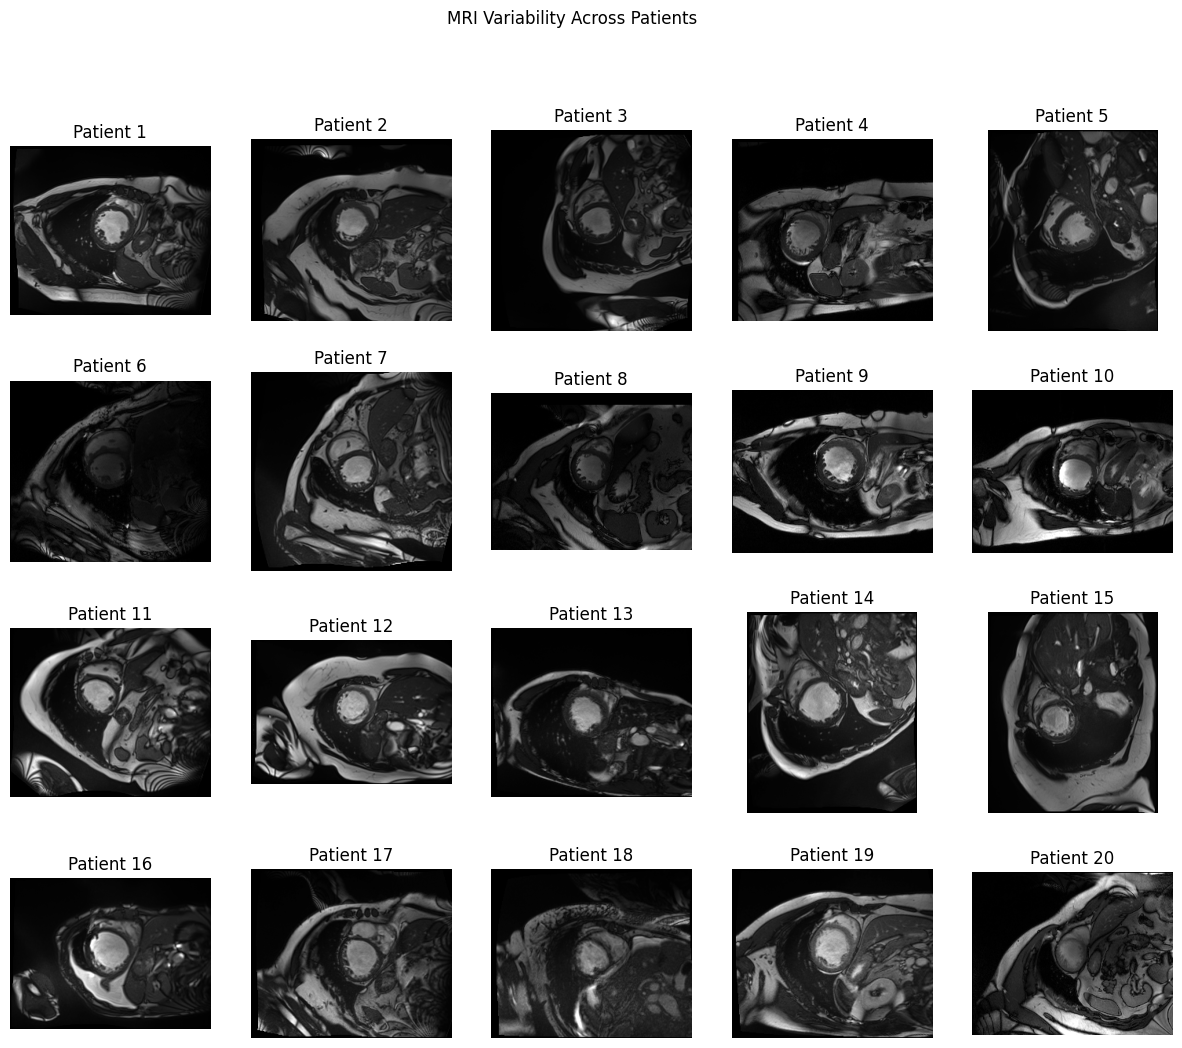

In [13]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i in range(20):
    patient = patients[i]
    patient_folder = os.path.join(mri_data_path, patient)
    sample_file = os.path.join(patient_folder, f"{patient}_4d.nii.gz")

    img = nib.load(sample_file).get_fdata()
    slice_idx = img.shape[2] // 2

    ax = axes[i // 5, i % 5]
    ax.imshow(img[:, :, slice_idx, 0], cmap="gray")
    ax.set_title(f"Patient {i+1}")
    ax.axis("off")

plt.suptitle("MRI Variability Across Patients")
plt.show()

All of these images are clear with well-defined parts. However, some of the scans (e.g. patient 6, patient 8) are darker and might cause issues with training the model, so I think the pixel values should be normalized, to ensure that darker images are adjusted to match the expected intensity range of the training data.

Also, I see another issue, which is that the images have different orientations (rotations and tilts). We might have to implement data augmentation during training to simulate different orientations and rotations. This way, the model will be more robust to such transformations.

The images also have different aspect ratios, so the resolutions should be different. This is also an issue, since in CNN, the input images should have the same fixed resolution. We can check how much do the resolutions vary and later we will deal with this by rescaling or cropping.

In [ ]:
shapes = []

for patient in sorted(os.listdir(mri_data_path)):
    patient_folder = os.path.join(mri_data_path, patient)
    for file in os.listdir(patient_folder):
        if file.endswith(".nii.gz") and "frame01" in file:
            img = nib.load(os.path.join(patient_folder, file))
            shapes.append(img.shape)

shapes = np.array(shapes)

unique_shapes = np.unique(shapes, axis=0)
print("Number of unique image shapes:", len(unique_shapes))

Number of unique image shapes: 56
